In [13]:
from datetime import datetime, timedelta
from calendar import monthrange
import numpy as np
import pandas as pd
import re
from datetime import timedelta
import akshare as ak
import os, time, math, random
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import matplotlib.pyplot as plt
print("AkShare version:", ak.__version__)

AkShare version: 1.17.61


In [27]:
# ---------- 常用小工具 ----------
global _EM_SESSION
if _EM_SESSION is None:
    _EM_SESSION = make_session_em()
s = _EM_SESSION
# s.get(url, timeout=s.request_timeout)

def normalize_ymd(s: str) -> str:
    """
    将形如 YYYYMMDD 的字符串规整为**存在的日期**。
    若日>当月天数，则取当月最后一天；若格式异常则抛错。
    """
    s = re.sub(r"\D", "", s)
    if len(s) != 8:
        raise ValueError(f"非法日期：{s}")
    y, m, d = int(s[:4]), int(s[4:6]), int(s[6:])
    if not (1 <= m <= 12):
        raise ValueError(f"非法月份：{s}")
    dim = monthrange(y, m)[1]
    d = min(max(d, 1), dim)
    return f"{y:04d}{m:02d}{d:02d}"

def ensure_dir(p: str):
    if not os.path.exists(p):
        os.makedirs(p, exist_ok=True)

def std_cols(df: pd.DataFrame) -> pd.DataFrame:
    """把 AkShare 的中英列名统一成英文，并设置 datetime 索引。"""
    colmap = {
        "日期":"date","date":"date",
        "开盘":"open","open":"open",
        "最高":"high","high":"high",
        "最低":"low","low":"low",
        "收盘":"close","close":"close",
        "成交量":"volume","volume":"volume",
        "成交额":"amount","amount":"amount",
    }
    df = df.rename(columns={c: colmap.get(c, c) for c in df.columns})
    if "date" not in df.columns or "close" not in df.columns:
        raise RuntimeError(f"缺少必要列：{list(df.columns)}")
    df["date"] = pd.to_datetime(df["date"])
    for k in ["open","high","low","close","volume","amount"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")
    df = df.sort_values("date").drop_duplicates(subset=["date"]).set_index("date")
    return df

def load_a_share_codes() -> pd.DataFrame:
    """
    读取 A 股代码表，返回 DataFrame(['code','name'])。
    过滤出 6 位数字代码（主板/创业/科创），不含北交所的 8 开头等。
    """
    tab = ak.stock_info_a_code_name()  # 含 A 股主板/创业/科创
    if {"code","name"}.issubset(tab.columns):
        df = tab[["code","name"]].copy()
    elif {"证券代码","证券简称"}.issubset(tab.columns):
        df = tab.rename(columns={"证券代码":"code","证券简称":"name"})[["code","name"]].copy()
    else:
        raise RuntimeError(f"无法识别代码/名称列：{list(tab.columns)}")
    df["code"] = df["code"].astype(str).str.strip()
    df = df[df["code"].str.fullmatch(r"\d{6}")]
    df = df.drop_duplicates(subset=["code"]).reset_index(drop=True)
    return df

def fetch_hist(symbol: str, start_ymd: str, end_ymd: str, adjust: str = "") -> pd.DataFrame:
    """
    先走 AkShare；遇到网络中断/限流类错误（如 RemoteDisconnected/Connection/Timeout），
    自动兜底走 push2his 直连；其他错误原样抛出。
    """
    try:
        raw = ak.stock_zh_a_hist(symbol=symbol, period="daily",
                                 start_date=start_ymd, end_date=end_ymd, adjust=adjust)
        return std_cols(raw)
    except Exception as e:
        msg = str(e)
        transient = ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg)
        if transient:
            # 兜底直连（依旧失败会抛 RuntimeError）
            return fetch_hist_em_direct(symbol, start_ymd, end_ymd, adjust)
        # 非网络类错误，直接抛出让上层处理（比如代码无效等）
        raise

def csv_path(symbol: str) -> str:
    return os.path.join(DATA_DIR, f"{symbol}.csv")


In [15]:
# ---------- 增量更新已有 CSV 到“今天” ----------

def update_all_to_latest(adjust: str = ADJUST, end_date: str | None = None):
    """
    遍历 DATA_DIR 下的 CSV：
    - 读取最后日期 last_dt
    - 从 last_dt+1 到 end_date（默认今天）拉取增量并合并去重
    """
    ensure_dir(DATA_DIR)
    today = datetime.now().strftime("%Y%m%d") if end_date is None else normalize_ymd(end_date)
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
    print(f"待更新文件数：{len(files)}，目标截止：{today}")

    for idx, fn in enumerate(sorted(files), 1):
        sym = fn.replace(".csv","")
        path = os.path.join(DATA_DIR, fn)
        try:
            df_old = pd.read_csv(path, parse_dates=["date"], dtype={"open":float,"high":float,"low":float,"close":float,"volume":float,"amount":float})
            df_old = df_old.set_index("date").sort_index()
            if df_old.empty:
                start = normalize_ymd(START_DATE_RAW)
            else:
                last_dt = df_old.index.max()
                start = (last_dt + timedelta(days=1)).strftime("%Y%m%d")

            if start > today:
                print(f"[{idx}/{len(files)}] 跳过 {sym}（已最新）")
                continue

            df_new = fetch_hist(sym, start, today, adjust)
            if df_new.empty:
                print(f"[{idx}/{len(files)}] {sym} 无增量")
                continue

            merged = pd.concat([df_old, df_new]).sort_index()
            merged = merged[~merged.index.duplicated(keep="last")]
            merged.to_csv(path, index=True)
            print(f"[{idx}/{len(files)}] 更新 {sym}：+{len(df_new)} 条，合计 {len(merged)}")
        except Exception as e:
            print(f"[{idx}/{len(files)}] 更新失败 {sym}：{repr(e)}")



In [32]:
# ---------- 模块三：画指定股票“过去两个月”的三条均线 ----------

def plot_three_ma(symbol: str, win_d=WIN_DAILY, win_w=WIN_WEEKLY, win_m=WIN_MONTH):
    """
    从 CSV（若不存在则在线抓取）读取数据；
    取“最近两个月（按日历月）”区间，画 4 条均线（含 60 日；不画K线）。
    """
    # 字体：尽量用系统中文，避免口字框（失败也不报错）
    try:
        from matplotlib import font_manager, rcParams
        rcParams["axes.unicode_minus"] = False
        for name in ["PingFang SC","Hiragino Sans GB","Microsoft YaHei","SimHei","Noto Sans CJK SC","Arial Unicode MS"]:
            try:
                font_manager.findfont(font_manager.FontProperties(family=name), fallback_to_default=False)
                rcParams["font.sans-serif"] = [name]; break
            except Exception:
                pass
    except Exception:
        pass

    path = csv_path(symbol)
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=["date"]).set_index("date").sort_index()
    else:
        df = fetch_hist(symbol, normalize_ymd(START_DATE_RAW), normalize_ymd(END_DATE_RAW), ADJUST)

    # 计算均线（简单移动均线）
    px   = df["close"].astype(float)
    ma_d = px.rolling(win_d, min_periods=1).mean()
    ma_w = px.rolling(win_w, min_periods=1).mean()
    ma_m = px.rolling(win_m, min_periods=1).mean()
    ma_60 = px.rolling(60, min_periods=1).mean()   # 新增 60 日均线

    # 过去两个月（按日历）
    last_day = px.index.max()
    start_dt = (last_day - pd.DateOffset(months=2)).normalize()
    sl = slice(start_dt, last_day)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.plot(ma_d.loc[sl].index,  ma_d.loc[sl].values,  label=f"{win_d}日均线")
    plt.plot(ma_w.loc[sl].index,  ma_w.loc[sl].values,  label=f"{win_w}日均线(≈周)")
    plt.plot(ma_m.loc[sl].index,  ma_m.loc[sl].values,  label=f"{win_m}日均线(≈月)")
    plt.plot(ma_60.loc[sl].index, ma_60.loc[sl].values, label="60日均线", linestyle="--")  # 虚线

    plt.title(f"{symbol} 过去两个月均线（含60日）")
    plt.xlabel("日期"); plt.ylabel("价格")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [17]:


def find_bull_cross_symbols180(
    win_s1: int = 5,
    win_s2: int = 10,
    win_s3: int = 20,
    win_l: int = 60,
    lookback: int = 1,
    data_dir: str = None,   # 若为 None 则用全局 DATA_DIR
) -> list[str]:
    """
    在 data_dir 下所有 CSV 中，查找满足：
      - 最近 'lookback' 根内，MA5、MA10、MA20 各自都出现“从下向上突破 MA60”的金叉
      - 且当前（最后一根） MA5 > MA60，MA10 > MA60，MA20 > MA60
    返回代码列表。

    当样本长度 < 60 时，使用“线性趋势反推 + 等权补全”的方式估算严格口径的 MA60：
      1) 用一阶线性回归拟合收盘价随时间的趋势；
      2) 向过去外推 (60 - n) 个点作为“虚拟历史”，并进行温和截断以避免极端值；
      3) 将“虚拟历史 + 实际数据”拼接后，做 60 长度等权滑动平均，再与原始索引对齐。
    """
    if data_dir is None:
        data_dir = DATA_DIR  # 兼容你现有的全局变量

    def estimate_ma60_strict(px: pd.Series, win: int) -> pd.Series:
        """
        若 len(px) >= win: 直接滚动均线（严格等权）；
        若 len(px) <  win: 用线性趋势向过去外推 (win-len) 个点补全后，再做严格等权的 rolling(win)。
        返回与 px 同一索引对齐的等权 MA(win)。
        """
        n = len(px)
        if n == 0:
            return pd.Series(index=px.index, dtype=float)

        if n >= win:
            return px.rolling(win, min_periods=win).mean().reindex(px.index)

        # —— n < win: 构造“虚拟历史” —— #
        # 用整数时间索引拟合线性趋势 y = a + b*t
        t_obs = np.arange(n, dtype=float)
        y_obs = px.values.astype(float)

        # 处理全常数或方差极小情况，避免奇异解
        if np.allclose(y_obs, y_obs[0], rtol=0, atol=1e-12):
            a, b = float(y_obs[0]), 0.0
        else:
            a, b = np.polyfit(t_obs, y_obs, 1)

        need = win - n
        t_back = np.arange(-need, 0, dtype=float)  # 负的时间步，向过去外推
        y_back = a + b * t_back

        # 温和 winsorize：以首尾观测值的范围做 20% 余量包络，避免外推失真过大
        lo = float(min(y_obs.min(), y_obs.max()) * 0.8)
        hi = float(max(y_obs.min(), y_obs.max()) * 1.2)
        y_back = np.clip(y_back, lo, hi)

        # 拼接：虚拟历史 + 实际数据（索引用简单整数，稍后对齐回原索引）
        y_ext = np.concatenate([y_back, y_obs])  # 长度恰好 = win
        idx_ext = np.arange(-need, n, dtype=int)
        s_ext = pd.Series(y_ext, index=idx_ext, dtype=float)

        # 在扩展序列上做严格等权 rolling(win)
        ma_ext = s_ext.rolling(win, min_periods=win).mean()

        # 将扩展的 rolling 均线对齐到原始观测索引（0..n-1）
        ma_on_obs = ma_ext.reindex(np.arange(0, n))
        ma_on_obs.index = px.index  # 对齐回日期索引
        return ma_on_obs

    def crossed_up(short_ma: pd.Series, long_ma: pd.Series, lb: int) -> bool:
        # 在过去 lb 根里，存在某一根 k： short<=long，下一根 short>long
        idx_len = len(long_ma)
        if idx_len < 2:
            return False
        for k in range(1, lb + 1):
            i_prev = -1 - k
            i_curr = -k
            if abs(i_prev) > idx_len or abs(i_curr) > idx_len:
                break
            sp, lp = float(short_ma.iloc[i_prev]), float(long_ma.iloc[i_prev])
            sc, lc = float(short_ma.iloc[i_curr]), float(long_ma.iloc[i_curr])
            if (sp <= lp) and (sc > lc):
                return True
        return False

    out = []
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

    for fn in files:
        sym = fn[:-4]
        try:
            df = (
                pd.read_csv(os.path.join(data_dir, fn), parse_dates=["date"])
                .set_index("date")
                .sort_index()
            )
            if "close" not in df.columns:
                continue

            px = df["close"].astype(float)
            n = len(px)
            if n < 2:
                continue

            # 计算短均线（允许短样本，min_periods=1 保证有值用于“当前>MA60”的判定）
            ma5  = px.rolling(win_s1, min_periods=1).mean()
            ma10 = px.rolling(win_s2, min_periods=1).mean()
            ma20 = px.rolling(win_s3, min_periods=1).mean()

            # 计算“严格口径”的 MA60（不足 60 用估算法补全后再 rolling）
            ma60 = estimate_ma60_strict(px, win_l)

            # 若估算返回有缺失（极端边界），跳过
            if ma60.isna().all():
                continue

            curr_idx = px.index[-1]

            # 当前必须都在 MA60 上方
            if not (
                (ma5.loc[curr_idx]  > ma60.loc[curr_idx]) and
                (ma10.loc[curr_idx] > ma60.loc[curr_idx]) and
                (ma20.loc[curr_idx] > ma60.loc[curr_idx])
            ):
                continue

            # 最近 lookback 根出现各自的“从下向上”金叉
            cond5  = crossed_up(ma5,  ma60, lookback)
            cond10 = crossed_up(ma10, ma60, lookback)
            cond20 = crossed_up(ma20, ma60, lookback)

            if cond5 and cond10 and cond20:
                out.append(sym)

        except Exception:
            # 单只异常不影响整体扫描
            continue

    return sorted(out)


In [18]:
# ================= 示例调用 =================
# 1) 批量下载（只需跑一次）
# batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST)

# 2) 增量更新到今天（可以隔天就跑一下）
# update_all_to_latest(ADJUST)

# 3) 画单只股票最近两个月的 3 条均线
# plot_three_ma("600519")  # 改成你想看的代码

# 4) 找出“月均线被周线和日均线从下向上突破”的股票并打印
# symbols = find_bull_cross_symbols(lookback=1)
# print("触发信号的股票：", symbols)


In [38]:
# OLD---------- 模块四：筛选“月均线被周线和日均线从下向上突破”的股票 ----------

def find_bull_cross_symbols(win_d=WIN_DAILY, win_w=WIN_WEEKLY, win_m=WIN_MONTH, lookback=1) -> list[str]:
    """
    在 DATA_DIR 下所有 CSV 中，查找满足：
      - 最近 'lookback' 根K线内，5日与10日均线均从下穿越到上方 20 日均线（各自“金叉”）
      - 且当前（最后一根） ma_d > ma_m 且 ma_w > ma_m
    返回代码列表。
    说明：默认 lookback=1 表示“刚刚发生在上一根→当前根上”（最严格）。
         若要放宽为最近 3 根内发生，把 lookback=3。
    """
    out = []
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
    for fn in files:
        sym = fn.replace(".csv","")
        try:
            df = pd.read_csv(os.path.join(DATA_DIR, fn), parse_dates=["date"]).set_index("date").sort_index()
            if len(df) < max(win_d, win_w, win_m) + 2:
                continue
            px = df["close"].astype(float)
            ma_d = px.rolling(win_d, min_periods=1).mean()
            ma_w = px.rolling(win_w, min_periods=1).mean()
            ma_m = px.rolling(win_m, min_periods=1).mean()

            # 最近两根：prev, curr
            curr = ma_d.index[-1]
            prev = ma_d.index[-2]

            # 当前必须在上方
            if not (ma_d.loc[curr] > ma_m.loc[curr] and ma_w.loc[curr] > ma_m.loc[curr]):
                continue

            # “从下向上突破”检测（最近 lookback 根内）
            def crossed_up(short_ma, long_ma, lb=lookback):
                # 在过去 lb 根里，存在某一根 k： short<=long，下一根 short>long
                idx = long_ma.index
                for k in range(1, lb+1):
                    i_prev = -1 - k
                    i_curr = -k
                    if i_prev < -len(idx):  # 长度不够
                        break
                    if (short_ma.iloc[i_prev] <= long_ma.iloc[i_prev]) and (short_ma.iloc[i_curr] > long_ma.iloc[i_curr]):
                        return True
                return False

            if crossed_up(ma_d, ma_m, lookback) and crossed_up(ma_w, ma_m, lookback):
                out.append(sym)

        except Exception:
            continue
    return sorted(out)

In [41]:
# ---------- 模块四：筛选“60日均线被月/周/日均线从下向上突破”的股票 ----------

def find_bull_cross_symbols_new(
    win_d: int = WIN_DAILY,    # 一般 5
    win_w: int = WIN_WEEKLY,   # 一般 10
    win_m: int = WIN_MONTH,    # 一般 20
    win_l: int = 60,           # 新增：长均线窗口（默认60）
    lookback: int = 3
) -> list[str]:
    """
    在 DATA_DIR 下所有 CSV 中，查找满足：
      - 最近 'lookback' 根K线内，MA(win_d)、MA(win_w)、MA(win_m) 各自都从下方上穿 MA(win_l)
      - 且当前（最后一根） MA(win_d)、MA(win_w)、MA(win_m) 均 > MA(win_l)
    返回代码列表（排序）。
    """
    out = []
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]

    # 上穿判定：过去 lb 根里，存在某一根 k： short<=long，下一根 short>long
    def crossed_up(short_ma: pd.Series, long_ma: pd.Series, lb: int) -> bool:
        n = len(long_ma)
        if n < 2:
            return False
        # 用 iloc 负索引向回看
        for k in range(1, lb + 1):
            i_prev = -1 - k
            i_curr = -k
            if abs(i_prev) > n or abs(i_curr) > n:
                break
            sp, lp = float(short_ma.iloc[i_prev]), float(long_ma.iloc[i_prev])
            sc, lc = float(short_ma.iloc[i_curr]), float(long_ma.iloc[i_curr])
            if (sp <= lp) and (sc > lc):
                return True
        return False

    for fn in files:
        sym = fn.replace(".csv", "")
        try:
            df = (
                pd.read_csv(os.path.join(DATA_DIR, fn), parse_dates=["date"])
                .set_index("date")
                .sort_index()
            )
            if "close" not in df.columns or len(df) < 2:
                continue

            px = pd.to_numeric(df["close"], errors="coerce").dropna()
            if len(px) < 2:
                continue

            # 简单移动均线（等权）；min_periods=1 以支持短样本，但上穿检测仍需至少2根
            ma_d  = px.rolling(win_d, min_periods=1).mean()
            ma_w  = px.rolling(win_w, min_periods=1).mean()
            ma_m  = px.rolling(win_m, min_periods=1).mean()
            ma_l  = px.rolling(win_l, min_periods=1).mean()  # 60日或自定义长均线

            curr = px.index[-1]

            # 当前必须都在 MA_long 上方
            if not (
                (ma_d.loc[curr] > ma_l.loc[curr]) and
                (ma_w.loc[curr] > ma_l.loc[curr]) and
                (ma_m.loc[curr] > ma_l.loc[curr])
            ):
                continue

            # 最近 lookback 根内，三条短均线均对 MA_long 发生“上穿”
            cond_d  = crossed_up(ma_d, ma_l, lookback)
            cond_w  = crossed_up(ma_w, ma_l, lookback)
            cond_m  = crossed_up(ma_m, ma_l, lookback)

            if cond_d and cond_w and cond_m:
                out.append(sym)

        except Exception:
            # 单文件异常忽略，继续扫描
            continue

    return sorted(out)


In [20]:
def batch_download_all_minimal(
    start_raw: str, end_raw: str, adjust: str = ADJUST,
    start_at: int = 1, resume_from_symbol: str | None = None,
    # —— 速率与冷却 —— 
    per_item_sleep: tuple[float,float] = (0.6, 1.2),
    rate_per_min: int = 15,
    cooldown_every: int = 60,
    cooldown_seconds: tuple[float,float] | float = (900, 1800),  # 更温和的强制冷却
    # —— 会话与断路器 —— 
    session_refresh_every: int = 120,
    circuit_fail_window: int = 5,
    circuit_fail_threshold: int = 3,
    circuit_sleep_range: tuple[float,float] = (1200, 1800),
    # —— 重试 —— 
    retry_per_symbol: int = 3,
    # —— 缺口判定（内部分段）——
    internal_gap_days: int = 8,  # 相邻记录间隔 > 8 天视为“可能缺口”（周末/节假日一般<4天）
):
    """
    仅下载缺口区间，最小化请求量；自动将新数据合并到每只股票已有 CSV 中，结果按时间升序。
    - 若 CSV 不存在：仅一次请求 [start, end]
    - 若存在：只请求 (start..min-1)、(max+1..end) 以及“明显内部分段缺口”
    """
    class RateLimiter:
        def __init__(self, rpm: int):
            self.interval = 60.0 / max(1, rpm)
            self.last = 0.0
        def sleep(self):
            now = time.time()
            wait = self.interval - (now - self.last)
            if wait > 0:
                time.sleep(wait)
            self.last = time.time()

    def _sleep_range(rng):
        if isinstance(rng, (tuple, list)) and len(rng) == 2:
            time.sleep(random.uniform(rng[0], rng[1]))
        elif isinstance(rng, (int, float)) and rng > 0:
            time.sleep(float(rng))

    def _minus_one_day(dt): return dt - timedelta(days=1)
    def _plus_one_day(dt):  return dt + timedelta(days=1)

    def _merge_write_csv(out_path: str, df_new: pd.DataFrame):
        # 要求 df_new index=DatetimeIndex，包含行情列；稳健合并并写回
        if df_new is None or len(df_new) == 0:
            return
        df_new = df_new.sort_index()
        if os.path.exists(out_path):
            try:
                df_old = pd.read_csv(out_path, parse_dates=["date"]).set_index("date").sort_index()
            except Exception:
                df_old = pd.DataFrame(index=pd.DatetimeIndex([], name="date"))
            # 统一列
            all_cols = sorted(set(df_old.columns) | set(df_new.columns))
            df_old = df_old.reindex(columns=all_cols)
            df_new = df_new.reindex(columns=all_cols)
            df_merged = pd.concat([df_old, df_new])
        else:
            df_merged = df_new
        # 去重（同日保留最后一条），再排序
        df_merged = df_merged[~df_merged.index.duplicated(keep="last")].sort_index()
        df_merged.to_csv(out_path, index=True)

    def _compute_missing_spans(existing_dates: pd.DatetimeIndex, start_dt: pd.Timestamp, end_dt: pd.Timestamp):
        """
        基于已有数据的最早/最晚时间点，外加“明显内部分段缺口”，给出需要补齐的最少连续区间列表。
        注意：我们不依赖交易日历，以“> internal_gap_days 天”作为缺口阈值，尽量减少内部请求次数。
        """
        spans = []

        if existing_dates is None or len(existing_dates) == 0:
            spans.append((start_dt, end_dt))
            return spans

        dmin, dmax = existing_dates.min(), existing_dates.max()

        # 1) 向前回补
        if start_dt < dmin:
            spans.append((start_dt, min(_minus_one_day(dmin), end_dt)))

        # 2) 向后增量
        if end_dt > dmax:
            spans.append((max(_plus_one_day(dmax), start_dt), end_dt))

        # 3) 明显内部分段缺口（仅当目标区间覆盖到这些段）
        # 排序后扫描相邻日期差
        ed = existing_dates[(existing_dates >= start_dt) & (existing_dates <= end_dt)]
        ed = ed.sort_values().unique()
        for i in range(1, len(ed)):
            gap = (ed[i] - ed[i-1]).days
            if gap > internal_gap_days:
                # 认为 (ed[i-1]+1 .. ed[i]-1) 可能缺失，加入一个连续区间
                left  = max(_plus_one_day(ed[i-1]), start_dt)
                right = min(_minus_one_day(ed[i]),   end_dt)
                if left <= right:
                    spans.append((left, right))

        # 合并可能相邻/重叠的 spans，减少请求次数
        if not spans:
            return spans
        spans = sorted(spans, key=lambda x: x[0])
        merged = []
        cur_s, cur_e = spans[0]
        for s, e in spans[1:]:
            if s <= cur_e + timedelta(days=1):
                cur_e = max(cur_e, e)
            else:
                merged.append((cur_s, cur_e))
                cur_s, cur_e = s, e
        merged.append((cur_s, cur_e))
        return merged

    # —— 主流程 —— #
    limiter = RateLimiter(rate_per_min)

    start = pd.to_datetime(normalize_ymd(start_raw))
    end   = pd.to_datetime(normalize_ymd(end_raw))
    ensure_dir(DATA_DIR)

    codes = load_a_share_codes()
    total = len(codes)

    if resume_from_symbol:
        mask = (codes["code"].astype(str).str.strip() == str(resume_from_symbol).strip())
        idxs = np.where(mask.values)[0]
        if len(idxs):
            start_at = int(idxs[0]) + 2
        else:
            print(f"提示：代码 {resume_from_symbol} 不在列表中，改用 start_at={start_at}")

    start_at = max(1, min(start_at, total))
    iter_df = codes.iloc[start_at-1:]

    ok_req = 0     # 成功请求次数（区间级）
    ok_sym = 0     # 至少有一次成功写入的股票数
    skip_sym = 0   # 无需下载的股票数
    fail_req = 0
    hits = 0
    recent_fails: list[bool] = []
    fail_log = []  # (sym, name, span, err)

    print(f"最小化下载计划：{total} 只；从 {start_at}/{total} 开始；区间 {start.date()}~{end.date()}；口径：{adjust or 'none'}")

    global _EM_SESSION

    for j, row in enumerate(iter_df.itertuples(index=False), start=start_at):
        sym, name = row.code, row.name
        out = csv_path(sym)

        # —— 断路器 —— #
        if len(recent_fails) >= circuit_fail_window and sum(recent_fails[-circuit_fail_window:]) >= circuit_fail_threshold:
            cool = random.uniform(*circuit_sleep_range)
            print(f"⛔ 连续失败触发断路器：休眠 {cool:.1f}s 并重建会话 …")
            time.sleep(cool)
            _EM_SESSION = make_session_em()
            recent_fails.clear()

        # —— 限速 & 随机抖动 —— #
        limiter.sleep()
        _sleep_range(per_item_sleep)

        # 周期性轮换会话
        hits += 1
        if session_refresh_every > 0 and (hits % session_refresh_every == 0):
            print("♻️ 轮换 EM 会话 …")
            _EM_SESSION = make_session_em()

        # —— 读取已有文件以确定缺口 —— #
        existing_idx = None
        if os.path.exists(out):
            try:
                old = pd.read_csv(out, parse_dates=["date"]).set_index("date").sort_index()
                existing_idx = old.index
            except Exception:
                existing_idx = None

        spans = _compute_missing_spans(existing_idx, start, end)

        if not spans:
            print(f"[{j}/{total}] {sym} {name}：无需下载（已覆盖 {start.date()}~{end.date()}）")
            skip_sym += 1
            continue

        wrote_any = False
        for (s_dt, e_dt) in spans:
            # 再防御：无效区间跳过
            if s_dt > e_dt:
                continue

            # —— 区间级重试（指数退避）—— #
            last_err = None
            success_span = False
            for t in range(retry_per_symbol):
                try:
                    df_new = fetch_hist(sym, s_dt.strftime("%Y-%m-%d"), e_dt.strftime("%Y-%m-%d"), adjust)
                    # 防御：确保 index 是 DatetimeIndex
                    if not isinstance(df_new.index, pd.DatetimeIndex):
                        if "date" in df_new.columns:
                            df_new = df_new.set_index(pd.to_datetime(df_new["date"]))
                            df_new.drop(columns=[c for c in ["date"] if c in df_new.columns], inplace=True, errors="ignore")
                        else:
                            # 如果 fetch_hist 返回没有索引的 DataFrame，尝试显式 parse
                            df_new.index = pd.to_datetime(df_new.index)

                    _merge_write_csv(out, df_new)
                    ok_req += 1
                    success_span = True
                    wrote_any = True
                    print(f"[{j}/{total}] {sym} {name}：补齐 {s_dt.date()}~{e_dt.date()}（{len(df_new)} 条）")
                    break
                except Exception as e:
                    last_err = e
                    msg = str(e)
                    # 网络类重试 → 指数退避，最大 24s
                    if ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg):
                        backoff = min(6 * (t + 1), 24)
                        print(f"[{j}/{total}] {sym} 区间 {s_dt.date()}~{e_dt.date()} 出错（{e}），{backoff}s 后重试({t+1}/{retry_per_symbol})…")
                        time.sleep(backoff)
                    else:
                        # 其他错误小退避
                        time.sleep(0.6)

            if not success_span:
                # 冷却兜底一次
                print(f"[{j}/{total}] {sym} 区间 {s_dt.date()}~{e_dt.date()} 常规重试已用尽，冷却 20s 后最后尝试一次…")
                time.sleep(20)
                try:
                    df_new = fetch_hist(sym, s_dt.strftime("%Y-%m-%d"), e_dt.strftime("%Y-%m-%d"), adjust)
                    if not isinstance(df_new.index, pd.DatetimeIndex):
                        if "date" in df_new.columns:
                            df_new = df_new.set_index(pd.to_datetime(df_new["date"]))
                            df_new.drop(columns=[c for c in ["date"] if c in df_new.columns], inplace=True, errors="ignore")
                        else:
                            df_new.index = pd.to_datetime(df_new.index)
                    _merge_write_csv(out, df_new)
                    ok_req += 1
                    wrote_any = True
                    print(f"[{j}/{total}] {sym} 冷却重试成功：{s_dt.date()}~{e_dt.date()}（{len(df_new)} 条）")
                except Exception as e2:
                    fail_req += 1
                    fail_log.append((sym, name, f"{s_dt.date()}~{e_dt.date()}", repr(last_err), repr(e2)))
                    print(f"[{j}/{total}] 仍失败 {sym} {name}：区间 {s_dt.date()}~{e_dt.date()} -> {repr(last_err)}；兜底仍失败：{repr(e2)}")

        recent_fails.append(not wrote_any)
        if len(recent_fails) > circuit_fail_window:
            recent_fails = recent_fails[-circuit_fail_window:]

        if wrote_any:
            ok_sym += 1

        if cooldown_every > 0 and (hits % cooldown_every == 0):
            _sleep_range(cooldown_seconds)
            print(f"📦 已发起 {hits} 次请求触发强制冷却。")

    print("\n—— 下载完成（最小化策略）——")
    print(f"股票覆盖：成功写入 {ok_sym} 只（至少有一个区间补齐），跳过 {skip_sym} 只（已完整），区间请求成功 {ok_req} 次，失败 {fail_req} 次。")
    if fail_log:
        print("\n以下区间失败（建议稍后单独重试或换网络/代理）：")
        for sym, name, span, e1, e2 in fail_log:
            print(f" - {sym} {name}  {span}  ->  {e1} | {e2}")


In [21]:
# === 配置区（按需修改） =========================================
DATA_DIR        = "ak_hist"  # 历史数据保存目录
START_DATE_RAW  = "20241231"                   # 允许写成不存在的日期，会自动规整
END_DATE_RAW    = "20250930"
ADJUST          = ""                           # 复权口径："" / "qfq" / "hfq"

# 均线窗口（单位：交易日）
WIN_DAILY  = 5    # “日均线” = 5日
WIN_WEEKLY = 10   # “周线”   = 10日（约两周）
WIN_MONTH  = 20   # “月均线” = 20日（约一月）

# 单只股票抓取重试
#RETRY_PER_SYMBOL = batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST)

In [22]:
batch_download_all_minimal(START_DATE_RAW, END_DATE_RAW, ADJUST, start_at=1, retry_per_symbol=3)

最小化下载计划：5436 只；从 1/5436 开始；区间 2024-12-31~2025-09-30；口径：none
[1/5436] 000001 区间 2024-12-31~2025-09-30 常规重试已用尽，冷却 20s 后最后尝试一次…


KeyboardInterrupt: 

In [28]:
global _EM_SESSION
_ = ensure_em_session()   # 保证 _EM_SESSION 已可用

def batch_download_all(
    start_raw: str, end_raw: str, adjust: str = ADJUST,
    start_at: int = 1, resume_from_symbol: str | None = None,
    per_item_sleep: tuple[float,float] = (0.6, 1.2),
    cooldown_every: int = 50,
    cooldown_seconds: tuple[float,float] | float = (1000, 3700),
    second_pass: bool = True,
    second_pass_cooldown: tuple[float,float] = (200, 260),
    # —— 稳态参数 —— 
    rate_per_min: int = 15,
    session_refresh_every: int = 100,
    circuit_fail_window: int = 5,
    circuit_fail_threshold: int = 3,
    circuit_sleep_range: tuple[float,float] = (1200, 1800),
    # —— 新参数：每只代码的常规重试次数（不含最后冷却兜底）——
    retry_per_symbol: int = 3,
):
    """
    分批下载所有 A 股历史到 CSV，带限速/冷却/会话轮换/断路器/失败二扫。
    """
    import random, time, os

    class RateLimiter:
        def __init__(self, rpm: int):
            self.interval = 60.0 / max(1, rpm)
            self.last = 0.0
        def sleep(self):
            now = time.time()
            wait = self.interval - (now - self.last)
            if wait > 0:
                time.sleep(wait)
            self.last = time.time()

    def _sleep_range(rng):
        if isinstance(rng, (tuple, list)) and len(rng) == 2:
            import random as _r
            time.sleep(_r.uniform(rng[0], rng[1]))
        elif isinstance(rng, (int, float)) and rng > 0:
            time.sleep(float(rng))

    limiter = RateLimiter(rate_per_min)

    start = normalize_ymd(start_raw)
    end   = normalize_ymd(end_raw)
    ensure_dir(DATA_DIR)

    codes = load_a_share_codes()
    total = len(codes)

    if resume_from_symbol:
        import numpy as np
        mask = (codes["code"].astype(str).str.strip() == str(resume_from_symbol).strip())
        idxs = np.where(mask.values)[0]
        if len(idxs):
            start_at = int(idxs[0]) + 2
        else:
            print(f"提示：代码 {resume_from_symbol} 不在列表中，改用 start_at={start_at}")

    start_at = max(1, min(start_at, total))
    iter_df = codes.iloc[start_at-1:]

    ok = fail = hits = 0
    fail_queue: list[tuple[str,str]] = []
    recent_fails: list[bool] = []

    print(f"计划下载：{total} 只；从第 {start_at}/{total} 开始；区间 {start}~{end}；口径：{adjust or 'none'}")

    global _EM_SESSION

    # ---------- 第一轮 ----------
    for j, row in enumerate(iter_df.itertuples(index=False), start=start_at):
        sym, name = row.code, row.name
        out = csv_path(sym)

        if os.path.exists(out):
            print(f"[{j}/{total}] 跳过 {sym} {name}（已存在）")
            continue

        # 断路器
        if len(recent_fails) >= circuit_fail_window and sum(recent_fails[-circuit_fail_window:]) >= circuit_fail_threshold:
            import random as _r
            cool = _r.uniform(*circuit_sleep_range)
            print(f"⛔ 连续失败触发断路器：休眠 {cool:.1f}s 并重建会话 …")
            time.sleep(cool)
            _EM_SESSION = make_session_em()
            recent_fails.clear()

        limiter.sleep()
        _sleep_range(per_item_sleep)

        hits += 1
        if session_refresh_every > 0 and (hits % session_refresh_every == 0):
            print("♻️ 轮换 EM 会话 …")
            _EM_SESSION = make_session_em()

        last_err = None
        success = False

        # 常规重试（指数退避）
        for t in range(retry_per_symbol):
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条")
                success = True
                break
            except Exception as e:
                last_err = e
                msg = str(e)
                if ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg):
                    backoff = min(6 * (t + 1), 24)
                    print(f"[{j}/{total}] {sym} 出错（{e}），{backoff}s 后重试({t+1}/{retry_per_symbol})…")
                    time.sleep(backoff)
                else:
                    time.sleep(0.6)

        if not success:
            print(f"[{j}/{total}] {sym} 常规重试已用尽，冷却 30s 后最后尝试一次…")
            time.sleep(30)
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条（冷却重试成功）")
                success = True
            except Exception as e2:
                fail += 1
                fail_queue.append((sym, name))
                print(f"[{j}/{total}] 失败 {sym} {name}：{repr(last_err)}；冷却重试仍失败：{repr(e2)}")

        recent_fails.append(not success)
        if len(recent_fails) > circuit_fail_window:
            recent_fails = recent_fails[-circuit_fail_window:]

        if success and cooldown_every > 0 and (hits % cooldown_every == 0):
            _sleep_range(cooldown_seconds)
            print(f"📦 已抓取 {hits} 只，完成强制冷却。")

    print(f"\n第一轮完成：成功 {ok}，失败 {fail}，目录：{os.path.abspath(DATA_DIR)}")

    # ---------- 第二轮 ----------
    if second_pass and fail_queue:
        print(f"\n开始二次扫描（失败 {len(fail_queue)} 只，慢速冷却重试）…")
        still_fail = []
        for idx, (sym, name) in enumerate(fail_queue, 1):
            print(f"[二次 {idx}/{len(fail_queue)}] 准备重试 {sym} {name}")
            _sleep_range(second_pass_cooldown)
            _EM_SESSION = make_session_em()
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(csv_path(sym), index=True)
                ok += 1; fail -= 1
                print(f"[二次 {idx}/{len(fail_queue)}] 成功 {sym}：{len(df)} 条")
            except Exception as e3:
                still_fail.append((sym, name, repr(e3)))
                print(f"[二次 {idx}/{len(fail_queue)}] 仍失败 {sym}：{repr(e3)}")

        if still_fail:
            print("\n以下代码在二次扫描后仍失败（建议稍后单独重试或换网络/代理）：")
            for sym, name, err in still_fail:
                print(f" - {sym} {name} -> {err}")

    print(f"\n最终统计：成功 {ok}，失败 {fail}，目录：{os.path.abspath(DATA_DIR)}")



In [29]:
# --- Session utils: Eastmoney/HTTP 通用会话工厂 + 全局兜底 ---
import requests
from requests.adapters import HTTPAdapter
try:
    # Retry 在 requests 2.32+ 仍在 urllib3.util.retry
    from urllib3.util.retry import Retry
except Exception:
    Retry = None

DEFAULT_HEADERS_EM = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    ),
    "Accept": "*/*",
    "Accept-Language": "zh-CN,zh;q=0.9,en;q=0.8",
    "Connection": "keep-alive",
    "Referer": "https://quote.eastmoney.com/",
}

def make_session_em(timeout_connect=5, timeout_read=15, total_retries=3, backoff=0.5, proxies=None):
    """
    创建带重试、长连接、UA/Referer 的 requests.Session。
    - proxies: 可传 {"http":"http://ip:port", "https":"http://ip:port"}
    """
    s = requests.Session()
    s.headers.update(DEFAULT_HEADERS_EM)

    if Retry is not None:
        retry = Retry(
            total=total_retries,
            connect=total_retries,
            read=total_retries,
            backoff_factor=backoff,
            status_forcelist=(429, 500, 502, 503, 504),
            allowed_methods=frozenset(["GET", "POST", "HEAD"]),
            raise_on_status=False,
        )
        adapter = HTTPAdapter(max_retries=retry, pool_connections=64, pool_maxsize=64)
    else:
        adapter = HTTPAdapter(pool_connections=64, pool_maxsize=64)

    s.mount("http://", adapter)
    s.mount("https://", adapter)

    # 默认超时（可在 fetch_hist 里用 s.get(url, timeout=(timeout_connect, timeout_read))）
    s.request_timeout = (timeout_connect, timeout_read)

    if proxies:
        s.proxies.update(proxies)

    return s

# 全局会话兜底（供 batch_* 使用）
try:
    _EM_SESSION
except NameError:
    _EM_SESSION = None  # 延迟初始化

def ensure_em_session():
    """若全局 _EM_SESSION 未建，则创建一个。"""
    global _EM_SESSION
    if _EM_SESSION is None:
        _EM_SESSION = make_session_em()
    return _EM_SESSION


In [ ]:
batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST, start_at=2299, retry_per_symbol=3)

计划下载：5436 只；从第 2299/5436 开始；区间 20241231~20250930；口径：none
[2299/5436] 保存 300865 大宏立：184 条
[2300/5436] 保存 300866 安克创新：184 条
[2301/5436] 保存 300867 圣元环保：184 条
[2302/5436] 保存 300868 杰美特：184 条
[2303/5436] 保存 300869 康泰医学：184 条
[2304/5436] 保存 300870 欧陆通：184 条
[2305/5436] 保存 300871 回盛生物：184 条
[2306/5436] 保存 300872 天阳科技：184 条
[2307/5436] 保存 300873 海晨股份：184 条
[2308/5436] 保存 300875 捷强装备：184 条
[2309/5436] 保存 300876 蒙泰高新：184 条
[2310/5436] 保存 300877 金春股份：184 条
[2311/5436] 保存 300878 维康药业：184 条
[2312/5436] 保存 300879 大叶股份：184 条
[2313/5436] 保存 300880 迦南智能：184 条
[2314/5436] 保存 300881 盛德鑫泰：184 条
[2315/5436] 保存 300882 万胜智能：184 条
[2316/5436] 保存 300883 龙利得：184 条
[2317/5436] 保存 300884 狄耐克：184 条
[2318/5436] 保存 300885 海昌新材：184 条
[2319/5436] 保存 300886 华业香料：184 条
[2320/5436] 保存 300887 谱尼测试：184 条
[2321/5436] 保存 300888 稳健医疗：184 条
[2322/5436] 保存 300889 爱克股份：184 条
[2323/5436] 保存 300890 翔丰华：184 条
[2324/5436] 保存 300891 惠云钛业：184 条
[2325/5436] 保存 300892 品渥食品：184 条
[2326/5436] 保存 300893 松原安全：184 条
[2327/5436] 保存 300894 火星人

In [55]:
symbols = find_bull_cross_symbols(lookback=1)
print("触发信号的股票：", symbols)

symbols180 = find_bull_cross_symbols_new(lookback=3)
print("触发信号的股票new：", symbols180)

触发信号的股票： ['000661', '000768', '001314', '002190', '002256', '002368', '002389', '002649', '002962', '300201', '300541', '300690']
触发信号的股票new： ['000708', '300464']


In [56]:
symbols = find_bull_cross_symbols_new(lookback=5)
print("触发信号的股票new：", symbols)

触发信号的股票new： ['000615', '000672', '000708', '300421', '300464']


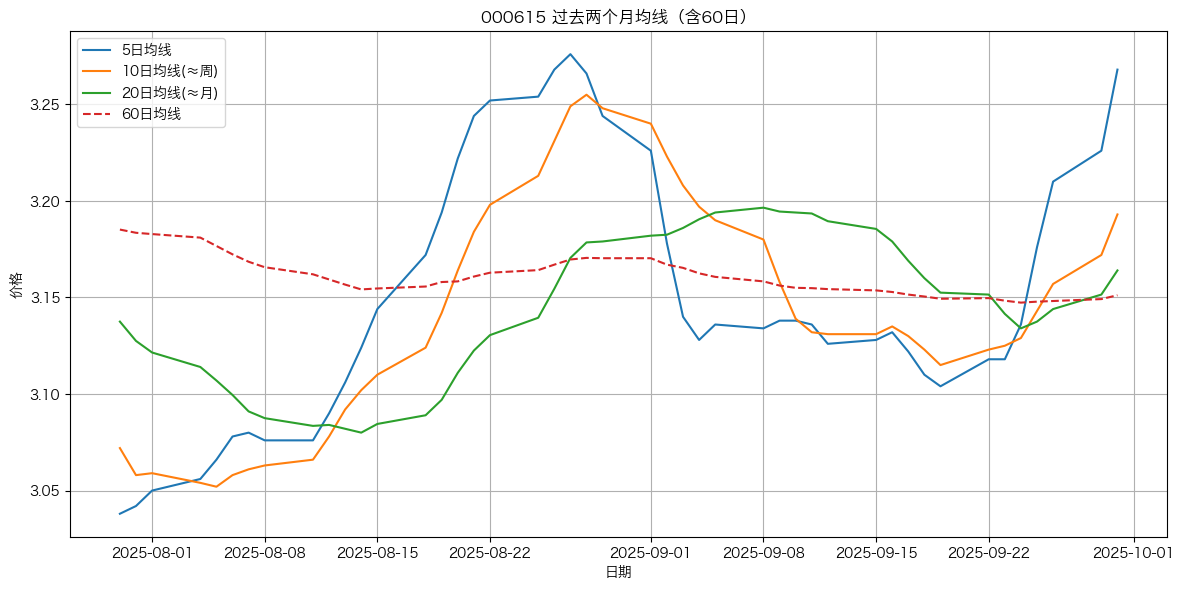

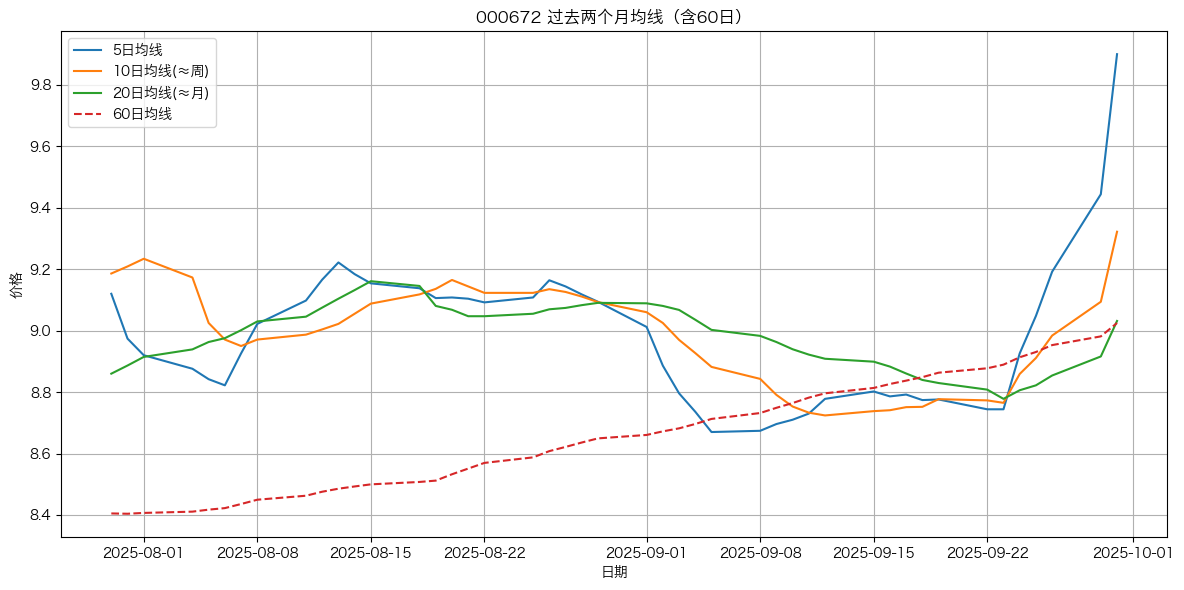

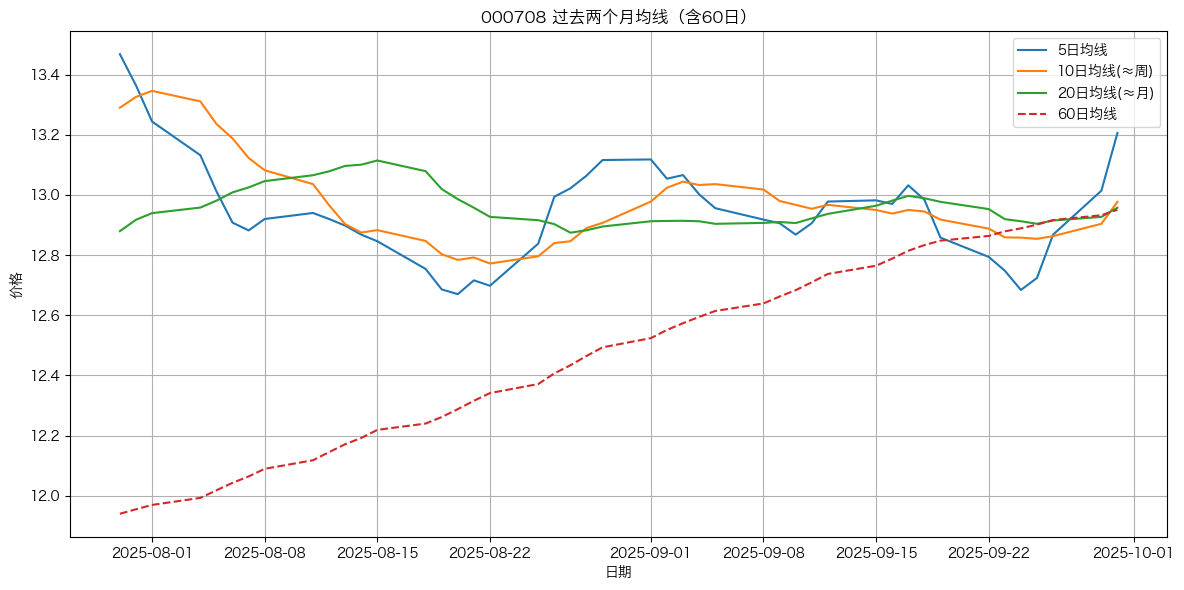

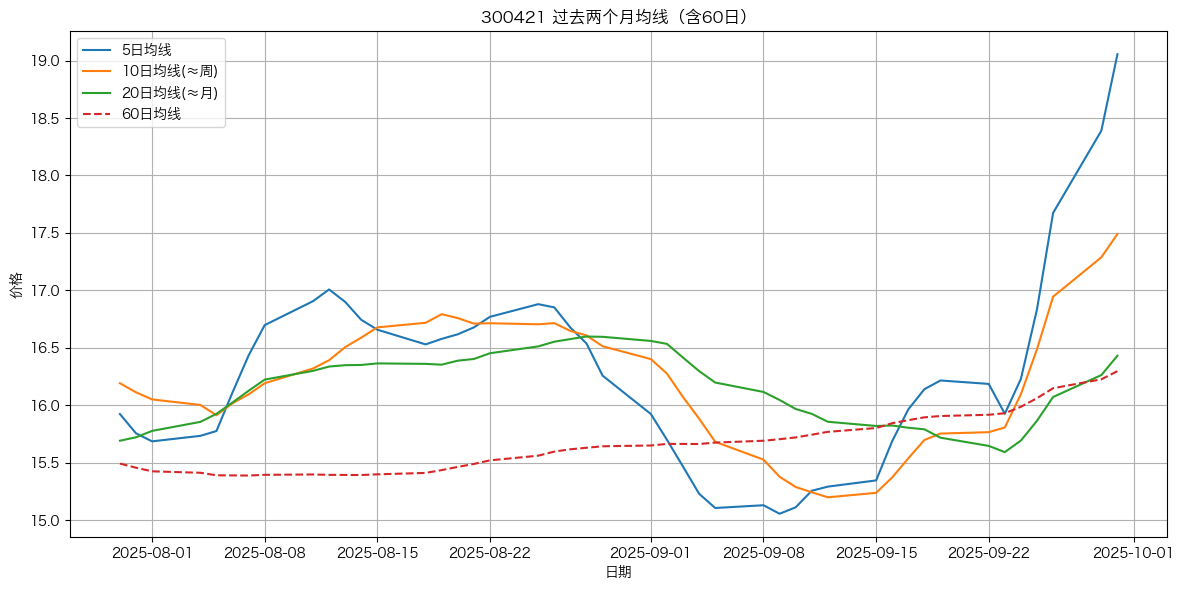

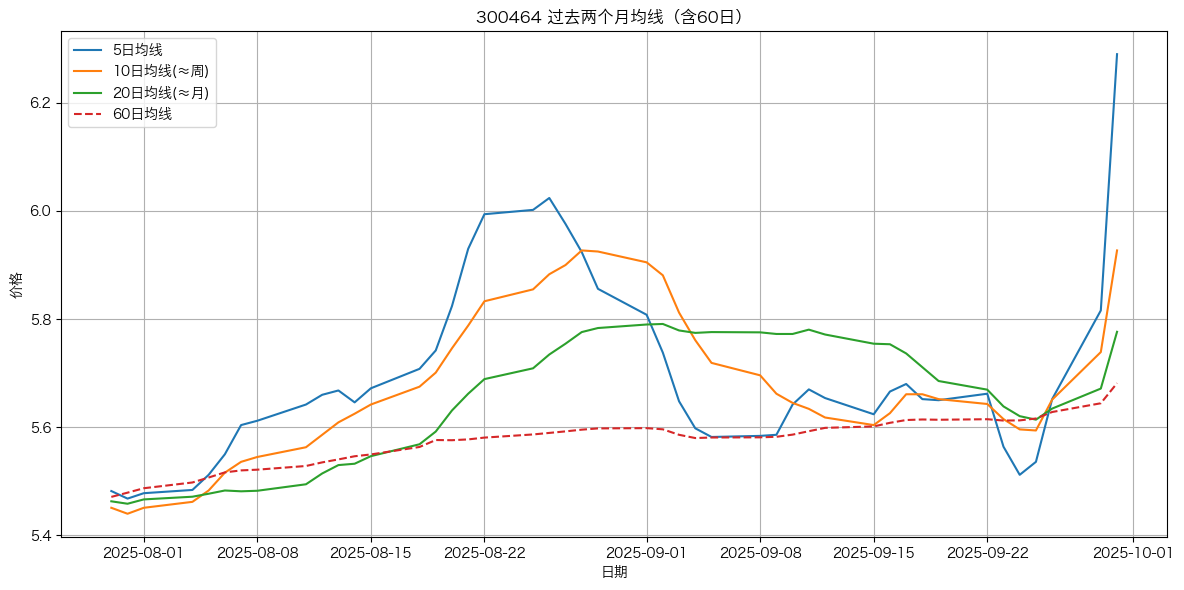

In [57]:
for i in symbols:
    plot_three_ma(i) 